In [1]:
# ===== Reduced Order Modeling with NGSolve + pyMOR (POD-Galerkin) =====
from ngsolve import *
from ngsolve import Mesh
from ngsolve import x, y, z
from ngsolve.webgui import Draw
from netgen.geom2d import unit_square
from netgen.occ import *

from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# ---------- Parameters ----------
L, W, H      = 3.0, 1.0, 1.0
baffle_thk   = 0.05
baffle_len   = 0.70*W
baffle_x     = [0.7, 1.5, 2.3]   # positions of the three baffles
half_model   = False
maxh         = 0.068  # mesh size

# stub parameters
Lin_ext  = 0.4   # inlet stub length
Lout_ext = 0.4   # outlet stub length
stub_frac = 0.5  # fraction of duct cross-section used for stub

# ---------- Main duct ----------
duct = Box(Pnt(0,0,0), Pnt(L, W, H))
duct.faces.name = "walls"

# ---------- Baffles ----------
fluid = duct
for i, x0 in enumerate(baffle_x, 1):
    x0min = x0 - 0.5*baffle_thk
    x0max = x0 + 0.5*baffle_thk
    zmin, zmax = 0, H

    if i == 2:  # middle baffle from TOP wall
        ymin, ymax = W - baffle_len, W
    else:       # side baffles from BOTTOM wall
        ymin, ymax = 0, baffle_len

    plate = Box(Pnt(x0min, ymin, zmin), Pnt(x0max, ymax, zmax))
    plate.faces.name = f"baffle{i}"
    fluid = fluid - plate

# ---------- Inlet stub ----------
stub_ymin = (1-stub_frac)/2 * W
stub_ymax = (1+stub_frac)/2 * W
stub_zmin = (1-stub_frac)/2 * H
stub_zmax = (1+stub_frac)/2 * H

stub_in = Box(Pnt(-Lin_ext, stub_ymin, stub_zmin),
              Pnt(0,        stub_ymax, stub_zmax))
stub_in.faces.name = "walls"           # stub sides are walls
stub_in.faces.Min(X).name = "inlet"    # only far end is inlet

# ---------- Outlet stub ----------
stub_out = Box(Pnt(L, stub_ymin, stub_zmin),
               Pnt(L+Lout_ext, stub_ymax, stub_zmax))
stub_out.faces.name = "walls"          # stub sides are walls
stub_out.faces.Max(X).name = "outlet"  # only far end is outlet

# ---------- Combine duct + stubs ----------
fluid = fluid + stub_in + stub_out

# ---------- Apply half-model cut if desired ----------
if half_model:
    sym_half = HalfSpace(Pnt(0, W/2, 0), Vec(0,1,0))
    fluid = fluid * sym_half

# ---------- Build OCC geometry and mesh ----------
geo = OCCGeometry(fluid)
m = geo.GenerateMesh(maxh=maxh)
mesh = Mesh(m)

print("Mesh elements:", mesh.ne)
print("Boundary names:", mesh.GetBoundaries())

# ---------- Count boundary elements ----------
counter = Counter()
for el in mesh.Elements(BND):
    counter[el.mat] += 1
print("Boundary facet counts:", counter)

# ---------- Visualize boundaries ----------
cf = mesh.BoundaryCF({
    "inlet":   10,
    "outlet":  20,
    "walls":   30,
    "baffle1": 40,
    "baffle2": 50,
    "baffle3": 60
}, default=0)

Draw(mesh)

Mesh elements: 64054
Boundary names: ('walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'walls', 'baffle1', 'baffle2', 'baffle2', 'baffle2', 'walls', 'walls', 'walls', 'baffle3', 'baffle3', 'baffle3', 'walls', 'baffle1', 'baffle1', 'inlet', 'walls', 'walls', 'walls', 'walls', 'outlet')
Boundary facet counts: Counter({'walls': 7146, 'baffle1': 710, 'baffle3': 704, 'baffle2': 694, 'inlet': 130, 'outlet': 122})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [ ]:
SetNumThreads(1)

# ------------ parameters ------------
nu_f      = 0.01          # viscosity
U0        = 1.0           # target peak inlet speed
omega0    = 0.3           # under-relaxation
tol       = 1e-4          # Picard stopping criterion
maxit     = 50            # allow more iterations if needed
gamma_gd  = 0.7           # grad-div penalty
use_backflow = True

# ------------ FE spaces ------------
V = VectorH1(mesh, order=1, dirichlet="walls|baffle1|baffle2|baffle3|inlet")
Q = H1(mesh, order=1)
fes = V*Q
(u, p), (v, q) = fes.TnT()

# inlet profile helper
def inlet_cf(U0):
    prof = U0 * (1 - (2*y/W-1)**2) * (1 - (2*z/H-1)**2)
    return CoefficientFunction((prof, 0, 0))

# lifting (velocity only)
def lifting(U0):
    g = GridFunction(fes)
    g.components[0].Set(inlet_cf(U0), BND, definedon=mesh.Boundaries("inlet"))
    return g

# ------------ Stokes warm-start ------------
gS = lifting(U0)  # directly use full U0

aS = BilinearForm(fes, symmetric=True)
aS += nu_f * InnerProduct(Grad(u), Grad(v)) * dx
aS += (-div(v)*p - q*div(u)) * dx
aS += 1e-12*p*q*dx
aS += gamma_gd * div(u)*div(v) * dx

fS = LinearForm(fes)
aS.Assemble(); fS.Assemble()
rhs = fS.vec.CreateVector(); rhs.data = fS.vec - aS.mat*gS.vec
sol = GridFunction(fes)
inv = aS.mat.Inverse(fes.FreeDofs(), inverse="pardiso")
sol.vec.data = gS.vec + inv*rhs

u_vel = GridFunction(V); u_vel.vec.data = sol.components[0].vec
p_prs = GridFunction(Q); p_prs.vec.data = sol.components[1].vec
print("Stokes L2(u) =", float(Integrate(Norm(u_vel), mesh)))

# ------------ Oseen iteration (direct to U0) ------------
n = specialcf.normal(3)
g = lifting(U0)
uk = GridFunction(V); uk.vec.data = u_vel.vec
omega = omega0
last_rel = None

for it in range(1, maxit+1):
    aO = BilinearForm(fes, symmetric=False)
    aO += nu_f * InnerProduct(Grad(u), Grad(v)) * dx
    aO += InnerProduct(Grad(u)*uk, v) * dx
    aO += (-div(v)*p - q*div(u)) * dx
    aO += 1e-12*p*q*dx
    aO += gamma_gd * div(u)*div(v) * dx

    if use_backflow:
        un = InnerProduct(uk, n)
        neg_un = IfPos(-un, -un, 0.0)   # penalize only backflow
        aO += 0.5*neg_un*InnerProduct(u, v) * ds(definedon=mesh.Boundaries("outlet"))

    fO = LinearForm(fes)
    aO.Assemble(); fO.Assemble()
    rhs = fO.vec.CreateVector(); rhs.data = fO.vec - aO.mat*g.vec
    sol = GridFunction(fes)
    inv = aO.mat.Inverse(fes.FreeDofs(), inverse="pardiso")
    sol.vec.data = g.vec + inv*rhs

    du  = GridFunction(V); du.vec.data = sol.components[0].vec - u_vel.vec
    rel = Norm(du.vec) / max(Norm(sol.components[0].vec), 1e-30)
    print(f"  iter {it:2d}: rel = {rel:.3e}, omega={omega:.2f}")

    # under-relaxed update
    u_vel.vec.data = (1-omega)*u_vel.vec + omega*sol.components[0].vec
    p_prs.vec.data = (1-omega)*p_prs.vec + omega*sol.components[1].vec
    uk.vec.data    = u_vel.vec

    if rel < tol:
        print("  converged.")
        break

    if last_rel is not None and rel > 1.25*last_rel and omega > 0.18:
        omega *= 0.7
    last_rel = rel

# ------------ Rescale velocity to U0 ------------
inlet_area = Integrate(1, mesh, BND, definedon=mesh.Boundaries("inlet"))
avg_inlet  = Integrate(Norm(u_vel), mesh, BND, definedon=mesh.Boundaries("inlet")) / inlet_area
scale = U0 / avg_inlet
print(f"\nScaling velocity field by factor {scale}")
u_vel.vec.data *= scale

avg_inlet_new = Integrate(Norm(u_vel), mesh, BND, definedon=mesh.Boundaries("inlet")) / inlet_area
print("new avg |u| on inlet =", avg_inlet_new)

# convection field for scalar problem
b = CoefficientFunction((u_vel[0], u_vel[1], u_vel[2]))
VTKOutput(ma=mesh, coefs=[u_vel], names=["u"], filename="solution_navier", subdivision=2).Do()


Stokes L2(u) = 1.035167233755331
  iter  1: rel = 3.075e-01, omega=0.30
  iter  2: rel = 2.283e-01, omega=0.30
  iter  3: rel = 1.714e-01, omega=0.30
  iter  4: rel = 1.298e-01, omega=0.30
  iter  5: rel = 9.886e-02, omega=0.30
  iter  6: rel = 7.567e-02, omega=0.30
  iter  7: rel = 5.811e-02, omega=0.30
  iter  8: rel = 4.471e-02, omega=0.30
  iter  9: rel = 3.443e-02, omega=0.30
  iter 10: rel = 2.651e-02, omega=0.30
  iter 11: rel = 2.041e-02, omega=0.30
  iter 12: rel = 1.569e-02, omega=0.30
  iter 13: rel = 1.205e-02, omega=0.30
  iter 14: rel = 9.241e-03, omega=0.30
  iter 15: rel = 7.077e-03, omega=0.30
  iter 16: rel = 5.412e-03, omega=0.30
  iter 17: rel = 4.132e-03, omega=0.30
  iter 18: rel = 3.151e-03, omega=0.30
  iter 19: rel = 2.399e-03, omega=0.30
  iter 20: rel = 1.824e-03, omega=0.30
  iter 21: rel = 1.385e-03, omega=0.30
  iter 22: rel = 1.050e-03, omega=0.30
  iter 23: rel = 7.954e-04, omega=0.30
  iter 24: rel = 6.016e-04, omega=0.30
  iter 25: rel = 4.546e-04, ome

'solution_navier'

In [4]:
# ------------------------------
# 1) Full-order model setup
# ------------------------------
supg_C=1.0
# FE space (scalar H1)
V = H1(mesh, order=1, dirichlet="walls|inlet|baffle1|baffle2|baffle3")
u, v = V.TnT()
proto = GridFunction(V).vec

# convection field b from NS velocity
b = CoefficientFunction((u_vel[0], u_vel[1], u_vel[2]))
bnorm = Norm(b) + 1e-12
hK  = specialcf.mesh_size
tau = supg_C * hK / bnorm                # simple, effective τ ~ h/|b|

A_diff = BilinearForm(V,symmetric=False)
A_diff += InnerProduct(grad(u), grad(v)) * dx
A_diff.Assemble()

A_adv = BilinearForm(V,symmetric=False)
A_adv += InnerProduct(b, grad(u)) * v * dx
A_adv += tau * (InnerProduct(b,grad(u))) * (InnerProduct(b,grad(v))) * dx
A_adv.Assemble()

# helper: boundary-lifting GridFunction g from {name: value/None}
def make_lifting(bc_vals: dict) -> GridFunction:
    """Create GridFunction g with boundary values; use None for Neumann parts."""
    g = GridFunction(V)
    names = list(mesh.GetBoundaries())
    vals  = [0.0 if bc_vals.get(nm, None) is None else float(bc_vals[nm]) for nm in names]
    g.Set(CoefficientFunction(vals), BND)
    return g


# Full-order solve
def solve_fom(g1, g2, g3, Pe) -> GridFunction:
    a = BilinearForm(V, symmetric=False)
    a += 1/Pe*InnerProduct(grad(u), grad(v)) * dx
    a += InnerProduct(b, grad(u)) * v * dx

    a += tau * (InnerProduct(b,grad(u))) * (InnerProduct(b,grad(v))) * dx
    a.Assemble()
    f = LinearForm(V)
    f.Assemble()

    bc_vals = {"walls":0.0, "inlet":0.0, "baffle1":g1, "baffle2":g2, "baffle3":g3, "outlet":None}
    g = make_lifting(bc_vals)
    rhs = f.vec.CreateVector()
    rhs.data = f.vec - a.mat * g.vec
    uN  = GridFunction(V)
    uN.vec.data = g.vec + a.mat.Inverse(V.FreeDofs()) * rhs
    return uN

In [5]:
from pymor.operators.numpy import NumpyMatrixOperator

# --- parameter snapshots (g1,g2,g3,Pe) ---
nsnaps = 50   # choose how many you want
g1_rand = np.random.uniform(0, 12, nsnaps)
g2_rand = np.random.uniform(0, 12, nsnaps)
g3_rand = np.random.uniform(0, 12, nsnaps)
Pe_rand = np.random.uniform(1, 600, nsnaps)

# combine into list of tuples
param_snaps = list(zip(g1_rand, g2_rand, g3_rand, Pe_rand))

snaps = []
for (g1, g2, g3, Pe) in param_snaps:
    u_full = solve_fom(g1, g2, g3, Pe)

    g = make_lifting({"walls":0.0, "inlet":0.0,
                      "baffle1":g1, "baffle2":g2, "baffle3":g3,
                      "outlet":None})

    w_np = u_full.vec.FV().NumPy() - g.vec.FV().NumPy()
    snaps.append(w_np.copy())

# --- POD on all chosen snapshots ---
N = len(snaps[0])
space   = NumpyVectorSpace(N)
snap_va = space.make_array(np.vstack(snaps))

# V inner product
V_mat = np.array(1/100*A_diff.mat.ToDense()+0.5*(A_adv.mat.ToDense() + A_adv.mat.ToDense().T))
product_op = NumpyMatrixOperator(V_mat)

RB, svals = pod(snap_va,product=product_op, rtol=1e-12, modes=None, l2_err=False)
# RB, svals = pod(snap_va,rtol=1e-12, modes=None, l2_err=False)
r  = len(RB)
Vr = np.column_stack([RB[i].to_numpy().ravel() for i in range(r)])   # N x r

print(f"Built POD space with {r} modes from {len(snaps)} param snapshots")


# A_times: apply A to a NumPy vector of size N. "Sparse multiply"
def A_times(vec_np: np.ndarray,A) -> np.ndarray:
    x = proto.CreateVector(); y = proto.CreateVector()
    if len(vec_np) != len(x.FV().NumPy()):
        raise ValueError(f"Dimension mismatch: got {len(vec_np)} vs FE dim {len(x.FV().NumPy())}")
    x.FV().NumPy()[:] = vec_np
    y.data = A.mat * x
    return y.FV().NumPy()



# Reduced operator A_rb and its inverse (dense, tiny)
A_V_diff  = np.column_stack([A_times(Vr[:, j], A_diff) for j in range(r)])        # N x r
A_V_adv  = np.column_stack([A_times(Vr[:, j], A_adv) for j in range(r)])        # N x r

f = LinearForm(V)
f.Assemble()


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Built POD space with 30 modes from 50 param snapshots


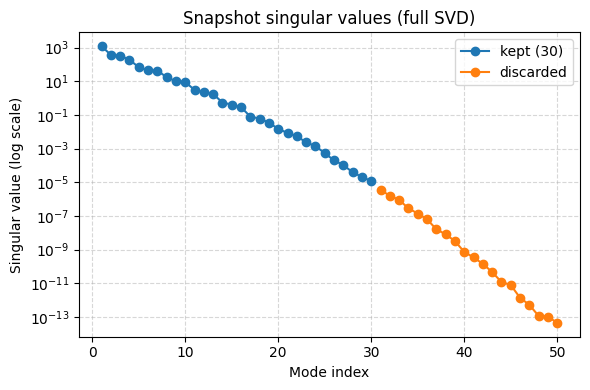

Sum of square singular values beyond cutoff (30): 6.509e-06
S ratio (tail) 2.8205e-09
S ratio (first) (30): 1.0000e+00


In [6]:
# stack snapshots into a matrix: (nsnaps, N)
svals_full = np.linalg.svd(snaps, compute_uv=False)

# indices
k = np.arange(1, len(svals_full)+1)

plt.figure(figsize=(6,4))
plt.semilogy(k[:r], svals_full[:r], 'o-', color='C0', label=f'kept ({r})')
plt.semilogy(k[r:], svals_full[r:], 'o-', color='C1', label='discarded')

plt.xlabel("Mode index")
plt.ylabel("Singular value (log scale)")
plt.title("Snapshot singular values (full SVD)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


s_squared = svals_full
tail_sum_s_vals = s_squared[r:].sum()
sum_first_r_s_vals = s_squared[:r].sum()

error_ratio_first = sum_first_r_s_vals / s_squared.sum()
error_ratio_tail = tail_sum_s_vals / s_squared.sum()
print(f"Sum of square singular values beyond cutoff ({r}): {tail_sum_s_vals:.3e}")
print(f"S ratio (tail) {error_ratio_tail:.4e}")
print(f"S ratio (first) ({r}): {error_ratio_first:.4e}")


In [7]:
# make fr consistent
def solve_reduced(g1, g2, g3, Pe, r=None):
    # slice the basis
    Vr_r = Vr[:, :r]                 # N x r
    A_V_diff_r = A_V_diff[:, :r]     # N x r
    A_V_adv_r  = A_V_adv[:, :r]      # N x r

    # recompute fr
    fr = Vr_r.T @ f.vec.FV().NumPy()

    # lifting
    g = make_lifting({"walls":0.0, "inlet":0.0,
                      "baffle1":g1, "baffle2":g2, "baffle3":g3,
                      "outlet":None})
    g_np = g.vec.FV().NumPy()

    # reduced operator
    Ar = Vr_r.T @ ((1/Pe) * A_V_diff_r + A_V_adv_r)

    # RHS: V^T (f - A g)
    Ag_np = (1/Pe) * A_times(g_np, A_diff) + A_times(g_np, A_adv)
    RHS = fr - Vr_r.T @ Ag_np

    # solve and reconstruct
    w_r  = np.linalg.solve(Ar, RHS)
    u_np = g_np + Vr_r @ w_r

    u = GridFunction(V)
    u.vec.FV().NumPy()[:] = u_np
    return u


gs = (6, 9, 12)
Pe = 100
u_rom = solve_reduced(*gs, Pe=Pe,r=11)
u_fom = solve_fom(*gs, Pe=Pe)

diff = GridFunction(V)
diff.vec[:] = u_fom.vec.FV().NumPy() - u_rom.vec.FV().NumPy()

# --- L2 error
L2_err = Integrate(diff*diff, mesh)
L2_ref = Integrate(u_fom*u_fom, mesh)
L2_rel = np.sqrt(L2_err / L2_ref)
print(f"Relative L2 error: {L2_rel:.3e}")

# --- H1 seminorm error
h1_err = Integrate(grad(diff)*grad(diff), mesh)
h1_ref = Integrate(grad(u_fom) * grad(u_fom), mesh)
h1_rel = np.sqrt(h1_err / h1_ref)
print(f"Relative H1 seminorm error: {h1_rel:.3e}")

# --- V-norm error
a_V = BilinearForm(V, symmetric=False)
a_V += (1/Pe) * InnerProduct(grad(u), grad(v)) * dx
a_V += InnerProduct(b, grad(u)) * v * dx
a_V += tau * (InnerProduct(b, grad(u))) * (InnerProduct(b, grad(v))) * dx
a_V.Assemble()

err_V2 = InnerProduct(a_V.mat * diff.vec, diff.vec)
ref_V2 = InnerProduct(a_V.mat * u_fom.vec, u_fom.vec)
V_rel  = np.sqrt(err_V2 / ref_V2)

print(f"Relative V-norm error: {V_rel:.3e}")


VTKOutput(ma=mesh, coefs=[u_rom, u_fom], names=["u_rom", "u_fom"], filename="rom_test", subdivision=2).Do()

Relative L2 error: 1.432e-03
Relative H1 seminorm error: 1.853e-03
Relative V-norm error: 2.360e-03


'rom_test'

Relative L2 error: 2.231e-07
Relative H1 seminorm error: 4.699e-07

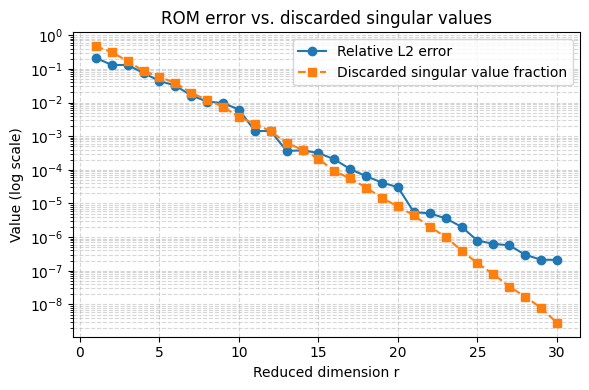

In [8]:
gs = (6, 9, 12)
u_fom = solve_fom(*gs, Pe=100)
errors = []
tails  = []
rs     = range(1, r+1)

for rtest in rs:
    # ROM solve
    u_rom = solve_reduced(*gs, Pe=100, r=rtest)

    # L2 error
    diff = GridFunction(V)
    diff.vec[:] = u_fom.vec.FV().NumPy() - u_rom.vec.FV().NumPy()
    relL2 = np.sqrt(Integrate(diff*diff, mesh) / Integrate(u_fom*u_fom, mesh))
    errors.append(relL2)

    # fraction of discarded singular values
    tail_frac = np.sum(svals_full[rtest:]) / np.sum(svals_full)
    # tail_frac = np.sum(svals_full[rtest:]) / len(svals_full)
    
    # tail_frac = np.sum(svals_full[rtest:]**2) / np.sum(svals_full**2)

    tails.append(tail_frac)

# --- plotting ---
plt.figure(figsize=(6,4))
plt.semilogy(rs, errors, 'o-', label="Relative L2 error")
plt.semilogy(rs, tails, 's--', label="Discarded singular value fraction")
plt.xlabel("Reduced dimension r")
plt.ylabel("Value (log scale)")
plt.title("ROM error vs. discarded singular values")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()



In [9]:
import numpy as np
import time

# number of random tests
Ntests = 10

# parameter ranges
g_low, g_high = 0.0, 12.0
Pe_low, Pe_high = 1.0, 600.0

# results storage
l2_errors = []
h1_errors = []
time_rom = []
time_fom = []

for i in range(Ntests):
    # random parameters
    g1 = np.random.uniform(g_low, g_high)
    g2 = np.random.uniform(g_low, g_high)
    g3 = np.random.uniform(g_low, g_high)
    Pe = np.random.uniform(Pe_low, Pe_high)
    # ROM solve timing
    t0 = time.time()
    u_rom = solve_reduced(g1, g2, g3, Pe)
    t1 = time.time()

    # FOM solve timing
    t2 = time.time()
    u_fom = solve_fom(g1, g2, g3, Pe)
    t3 = time.time()

    time_rom.append(t1 - t0)
    time_fom.append(t3 - t2)

    # wrap into GridFunctions for error calculation

    diff = GridFunction(V); diff.vec[:] = u_fom.vec.FV().NumPy() - u_rom.vec.FV().NumPy()

    # relative L2 error
    L2_err = Integrate(diff*diff, mesh)
    L2_ref = Integrate(u_fom*u_fom, mesh)
    rel_l2 = (L2_err / L2_ref)**0.5

    # relative H1 seminorm error
    h1_err = Integrate(grad(diff)*grad(diff), mesh)
    h1_ref = Integrate(grad(u_fom)*grad(u_fom), mesh)
    rel_h1 = (h1_err/h1_ref)**0.5

    l2_errors.append(rel_l2)
    h1_errors.append(rel_h1)

    print(f"[{i+1}/{Ntests}] g1={g1:.2f}, g2={g2:.2f}, g3={g3:.2f}, Pe={Pe:.1f} "
          f"--> L2={rel_l2:.3e}, H1={rel_h1:.3e}")



# summarize
print("\n=== Summary over", Ntests, "tests ===")
print(f"ROM avg time: {np.mean(time_rom):.4f}s, max: {np.max(time_rom):.4f}s")
print(f"FOM avg time: {np.mean(time_fom):.4f}s, max: {np.max(time_fom):.4f}s")

print(f"Relative L2 error: mean={np.mean(l2_errors):.3e}, max={np.max(l2_errors):.3e}")
print(f"Relative H1 error: mean={np.mean(h1_errors):.3e}, max={np.max(h1_errors):.3e}")


[1/10] g1=9.81, g2=0.90, g3=11.88, Pe=216.7 --> L2=1.798e-08, H1=2.965e-08
[2/10] g1=10.39, g2=4.91, g3=0.76, Pe=173.7 --> L2=1.404e-08, H1=2.254e-08
[3/10] g1=8.31, g2=11.11, g3=4.35, Pe=240.1 --> L2=8.783e-09, H1=1.423e-08
[4/10] g1=7.27, g2=8.44, g3=10.67, Pe=324.7 --> L2=2.076e-09, H1=3.412e-09
[5/10] g1=11.69, g2=4.35, g3=1.00, Pe=177.0 --> L2=8.684e-09, H1=1.385e-08
[6/10] g1=9.95, g2=2.82, g3=9.26, Pe=243.1 --> L2=2.736e-08, H1=4.437e-08
[7/10] g1=10.10, g2=3.55, g3=10.01, Pe=243.9 --> L2=2.555e-08, H1=4.151e-08
[8/10] g1=9.98, g2=3.75, g3=8.15, Pe=94.2 --> L2=3.447e-07, H1=5.054e-07
[9/10] g1=3.00, g2=1.00, g3=6.34, Pe=421.2 --> L2=6.592e-09, H1=1.002e-08
[10/10] g1=1.40, g2=7.27, g3=7.22, Pe=303.3 --> L2=8.578e-09, H1=1.359e-08

=== Summary over 10 tests ===
ROM avg time: 0.0160s, max: 0.0190s
FOM avg time: 2.8691s, max: 3.3628s
Relative L2 error: mean=4.643e-08, max=3.447e-07
Relative H1 error: mean=6.985e-08, max=5.054e-07


In [10]:
def compute_error_estimator(u_rom: GridFunction, Pe: float):
    """
    Compute RB a posteriori error estimator Δ_N(μ).
    u_rom : reduced solution as GridFunction
    Pe    : Peclet number (parameter)
    """
    # Assemble full operator A(Pe)
    a_full = BilinearForm(V, symmetric=False)
    a_full += (1/Pe) * InnerProduct(grad(u), grad(v)) * dx
    a_full += InnerProduct(b, grad(u)) * v * dx
    a_full += tau * (InnerProduct(b, grad(u))) * (InnerProduct(b, grad(v))) * dx
    a_full.Assemble()
    A = a_full.mat

    # Residual r = f - A u_rom
    r_vec = f.vec.CreateVector()
    r_vec.data = f.vec - A * u_rom.vec

    # Dual norm: sqrt( r^T A^{-1} r )
    invA = A.Inverse(V.FreeDofs(), inverse="pardiso")
    eta2 = InnerProduct(r_vec, invA * r_vec)
    eta  = np.sqrt(eta2)

    # Coercivity bound β(μ): here just assume = 1.0 for demo
    beta_lb = 1.0

    return eta / beta_lb
gs = (6, 9, 12)
Pe = 100
u_rom = solve_reduced(*gs, Pe=Pe)
u_fom = solve_fom(*gs, Pe=Pe)

# true error
diff = GridFunction(V)
diff.vec.data = u_fom.vec - u_rom.vec
true_err = np.sqrt(Integrate(diff*diff, mesh))

# estimator
deltaN = compute_error_estimator(u_rom, Pe)

print(f"True L2 error    = {true_err:.3e}")
print(f"Estimator Δ_N(μ) = {deltaN:.3e}")


True L2 error    = 1.219e-06
Estimator Δ_N(μ) = 1.925e-06
